### Working on the nnpz task

See: https://redmine.astro.unige.ch/issues/15518

Downloaded catalogs and filters from Jean's area into /data/dc3. Copied SEDs from Phosphoros quickstart.

Tried to run using the 10x catalogs, but there are duplicated IDs, so Phosphoros failed. It seems the 10x is just
the same as the other catalog, but each entry 10 times.

Luckily I didn't run with the full set, or it would have taken forever. In any case, if they are exactly identical,
just 10 times repeated (to be checked, I may be wrong), I may as well replicate the result 10 times.

Run Phosphoros GUI, configure filters, generate the parameter space using the Quickstart values, and run the
template fitting.
After a couple of hours and burning CPU at 100%, got an output.

Run my [ph2ref](https://gitlab.astro.unige.ch/aalvarez/ph2ref) script on the Phosphoros output to generate a reference sample under /data/dc3/ReferenceSample

In [3]:
import nnpz
from astropy.table import Table

In [3]:
ref = nnpz.ReferenceSample('/data/dc3/ReferenceSample/')
print(ref.size())

518216


Run NnpzBuildPhotometry over the just created RefernceSample
```bash
./NnpzBuildPhotometry --sample-dir "/data/dc3/ReferenceSample" --filters "/data/dc3/AuxiliaryData/Filters/Euclid" --out-type F_nu_uJy --out-file "/data/dc3/DC3.2.0_F_nu_uJy.fits"
```

Run in 263.36s. An excerpt:

In [12]:
photometry = Table.read('/data/dc3/DC3.2.0_F_nu_uJy.fits', hdu=1)
photometry[0:5]

ID,g,r,J,Y,i,H,z,u,vis
int64,float32,float32,float32,float32,float32,float32,float32,float32,float32
216439,5.94379e+15,1.26111e+16,3.30109e+16,2.93887e+16,1.75996e+16,3.7315e+16,2.42022e+16,1.27347e+15,1.44539e+16
218604,5.40076e+15,1.02661e+16,2.16418e+16,1.97281e+16,1.34469e+16,2.34639e+16,1.71872e+16,1.44529e+15,1.13922e+16
219020,5.28514e+15,9.73779e+15,1.95312e+16,1.79251e+16,1.25439e+16,2.09468e+16,1.57865e+16,1.47245e+15,1.0722e+16
219656,3.03014e+15,3.09651e+15,3.01943e+15,3.18958e+15,3.16121e+15,2.93183e+15,3.31571e+15,1.96949e+15,3.12577e+15
219657,3.97374e+15,5.89777e+15,1.21127e+16,1.09102e+16,7.29244e+15,1.34564e+16,9.34767e+15,1.75235e+15,6.42259e+15


Create a new config file, and use that one to run nnpz
```python
reference_sample_dir = '/data/dc3/ReferenceSample'
reference_sample_phot_file = '/data/dc3/DC3.2.0_F_nu_uJy.fits'
reference_sample_phot_filters = ['u', 'g', 'r', 'i', 'z', 'vis', 'Y', 'J', 'H']
out_mean_phot_filters = reference_sample_phot_filters

target_cat = '/data/dc3/Catalog/Cosmos/euclid_emulated_DC3.2.0_COSMOS15_test.fits'
target_filters = [
    ('u_obs', 'u_obs_err'),
    ('g_obs', 'g_obs_err'),
    ('r_obs', 'r_obs_err'),
    ('i_obs', 'i_obs_err'),
    ('z_obs', 'z_obs_err'),
    ('vis_obs', 'vis_obs_err'),
    ('Y_obs', 'Y_obs_err'),
    ('J_obs', 'J_obs_err'),
    ('H_obs', 'H_obs_err')
]
missing_photometry_flags = [-99]

neighbor_method = 'Combined'

batch_size = 2000
neighbors_no = 30

input_size = 1000

output_file = '/data/dc3/nnpz/out.fits'
```

When running, this line takes a long time, and no feedback is available on the terminal :(
```python
selector = EuclideanRegionBruteForceSelector(neighbors_no, batch_size).initialize(ref_data)
```

Regenerated the photometries but with F_lambda, not sure if that's ok, need to ask. The values from the
previous one were too far away.

In [13]:
photometry_lambda = Table.read('/data/dc3/DC3.2.0_F_lambda.fits', hdu=1)
photometry_lambda[0:5]

ID,g,r,J,Y,i,H,z,u,vis
int64,float32,float32,float32,float32,float32,float32,float32,float32,float32
216439,0.00780618,0.0092537,0.00540401,0.00758704,0.00872465,0.00363316,0.00871057,0.00284716,0.00902161
218604,0.00709301,0.00753299,0.00354284,0.00509306,0.00666605,0.00228456,0.0061858,0.00323129,0.00711058
219020,0.00694116,0.00714534,0.00319733,0.00462758,0.00621838,0.00203948,0.00568171,0.00329203,0.00669232
219656,0.00397959,0.00227214,0.000494291,0.00082343,0.0015671,0.000285457,0.00119335,0.00440326,0.00195099
219657,0.00521885,0.00432763,0.0019829,0.00281661,0.00361508,0.00131018,0.0033643,0.0039178,0.00400876


So, indeed the results were wrong. The SEDs can not be just pulled into the reference sample like that. I should have been using a pre-generated reference sample instead, and not having to do all this. At least ph2ref may turn out to be useful, as it is something that will be have to be done anyways.

Nk will send me a proper reference sample to run. Also, had to filter the catalog and use only those that have a ratio vis/vis_error > 10

In [15]:
filtered_catalog = Table.read('/data/dc3/Catalog/Cosmos/euclid_test_filtered_vist.fits')
filtered_catalog[0:5]

ID,ra,dec,z_true,has_spec_z,weight,radius,u_obs,u_obs_err,u_obs_mag,u_obs_mag_err,g_obs,g_obs_err,g_obs_mag,g_obs_mag_err,r_obs,r_obs_err,r_obs_mag,r_obs_mag_err,i_obs,i_obs_err,i_obs_mag,i_obs_mag_err,z_obs,z_obs_err,z_obs_mag,z_obs_mag_err,vis_obs,vis_obs_err,vis_obs_mag,vis_obs_mag_err,Y_obs,Y_obs_err,Y_obs_mag,Y_obs_mag_err,J_obs,J_obs_err,J_obs_mag,J_obs_mag_err,H_obs,H_obs_err,H_obs_mag,H_obs_mag_err
,deg,deg,,,,,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,mag,mag
int64,float64,float64,float32,int16,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
216439,149.697605634,1.61663899668,0.0386,0,1.52003949881,5.29918,-1.61687,1.16311,-1.0,-1.0,3.20732,0.508503,22.6346,0.197281,6.9601,0.883043,21.7935,0.153647,8.04782,1.16375,21.6358,0.148437,9.27998,1.39809,21.4811,0.135787,6.7884,0.466793,21.8206,0.0723167,16.562,2.04905,20.8522,0.159326,14.7172,2.05301,20.9804,0.142293,19.8649,2.06533,20.6548,0.122692
218604,149.749392908,1.61806787407,0.3797,0,2.04923844337,0.971324,1.15183,0.228525,23.7465,0.182664,9.07489,0.115342,21.5054,0.0136015,45.0217,0.221116,19.7664,0.00533363,77.0638,0.297251,19.1829,0.00416721,103.175,0.31891,18.8661,0.00335541,55.8513,0.197614,19.5324,0.00384457,132.436,1.1472,18.595,0.00929858,189.365,1.34702,18.2068,0.00774545,220.849,1.56645,18.0398,0.00762718
219020,150.125092889,1.6169004891,0.16,0,6.22653222084,1.47236,14.6935,0.423113,20.9822,0.0310942,77.3928,0.243204,19.1782,0.00340383,235.867,0.423856,17.9683,0.00194743,345.284,0.543979,17.5546,0.00171097,462.88,0.559434,17.2363,0.00131094,274.957,0.416716,17.8018,0.00164398,629.362,2.41297,16.9027,0.00418714,779.196,2.6894,16.6709,0.00374976,915.959,3.13362,16.4953,0.00371911
219965,150.405519262,1.61906231087,0.0962,0,1.62137550116,1.80295,18.8277,0.50083,20.713,0.0291145,67.6201,0.253453,19.3248,0.00404382,143.624,0.403345,18.5069,0.00304754,201.809,0.518031,18.1376,0.00278591,256.312,0.561814,17.8781,0.00237983,163.706,0.343472,18.3648,0.00228432,305.651,1.77891,17.6869,0.00631399,343.068,1.87867,17.5616,0.00592667,408.94,2.16321,17.3708,0.0057996
219996,150.328351774,1.61472055804,0.5502,0,1.53129905462,0.601325,0.17203,0.135868,25.811,0.690558,0.290801,0.0588502,25.241,0.212888,0.421461,0.101435,24.8381,0.193052,0.665566,0.133302,24.342,0.205402,1.0289,0.159338,23.8691,0.224845,0.603768,0.0556442,24.4478,0.100849,0.557744,0.247079,24.5339,0.275642,1.23932,0.251213,23.667,0.228012,1.44826,0.258692,23.4979,0.202085


In [20]:
import functools
import operator

functools.reduce(operator.and_, ((filtered_catalog['vis_obs'] / filtered_catalog['vis_obs_err']) > 10))

True

#### Let's go again
Running again with the proper data. This time NK gave also the photometry.

In [2]:
ref = nnpz.ReferenceSample('/data/dc3/ReferenceSample/')
print(ref.size())

1000


In [7]:
photometry = Table.read('/data/dc3/ReferenceSample/phot_F_nu_uJy.fits', hdu=1)
photometry[0:5]

ID,vis,u,g,H,r,Y,z,i,J
int64,float32,float32,float32,float32,float32,float32,float32,float32,float32
121295,26.4869,18.4824,32.8555,25.828,27.3304,20.7665,23.1308,26.0305,22.2821
128954,16.6726,8.54999,11.6453,39.9057,14.6643,32.3152,27.7186,19.3509,35.0325
136007,5.29038,0.362386,0.767606,58.3095,3.22579,21.4571,13.8873,8.91877,35.6717
141392,5.7108,4.04466,5.03874,12.3457,5.60821,8.6494,7.36713,5.87749,10.6898
144814,0.782583,0.0425814,0.120669,18.1678,0.429319,6.2394,3.23257,1.19749,11.0263


In [37]:
%matplotlib inline
import matplotlib.pyplot as pyplot
import numpy as np

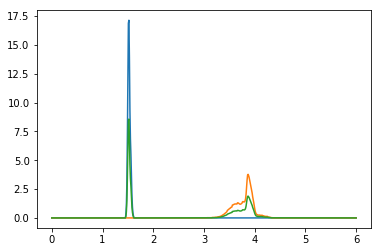

In [28]:
ids = ref.getIds()
pdz1 = ref.getPdzData(ids[100])
pdz2 = ref.getPdzData(ids[500])
test = pdz1 * 0.5 + pdz2 * 0.5
pyplot.plot(pdz1[:,0], pdz1[:,1])
pyplot.plot(pdz2[:,0], pdz2[:,1])
pyplot.plot(test[:,0], test[:,1])

I *think* something like that is what it has to be done.

In [32]:
ref.getPdzData(ids[0])[:,0]

array([ 0.        ,  0.01      ,  0.02      ,  0.03      ,  0.04      ,
        0.05      ,  0.06      ,  0.07      ,  0.08      ,  0.09      ,
        0.1       ,  0.11      ,  0.12      ,  0.13      ,  0.14      ,
        0.15000001,  0.16      ,  0.17      ,  0.18000001,  0.19      ,
        0.2       ,  0.20999999,  0.22      ,  0.23      ,  0.23999999,
        0.25      ,  0.25999999,  0.27000001,  0.28      ,  0.28999999,
        0.30000001,  0.31      ,  0.31999999,  0.33000001,  0.34      ,
        0.34999999,  0.36000001,  0.37      ,  0.38      ,  0.38999999,
        0.40000001,  0.41      ,  0.41999999,  0.43000001,  0.44      ,
        0.44999999,  0.46000001,  0.47      ,  0.47999999,  0.49000001,
        0.5       ,  0.50999999,  0.51999998,  0.52999997,  0.54000002,
        0.55000001,  0.56      ,  0.56999999,  0.57999998,  0.58999997,
        0.60000002,  0.61000001,  0.62      ,  0.63      ,  0.63999999,
        0.64999998,  0.66000003,  0.67000002,  0.68000001,  0.69

Let's see. The first implementation is done. Preview:

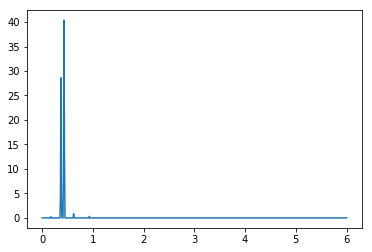

In [55]:
nnpz_out = Table.read('/data/dc3/nnpz/out.fits')
pdz_vals, pdz_bins = nnpz_out[0]['CoaddedPdz'], nnpz_out[0]['CoaddedPdzBins']
pyplot.plot(pdz_bins, pdz_vals)

In [56]:
np.trapz(pdz_vals, pdz_bins)

0.99999994

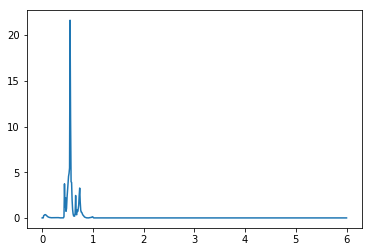

In [57]:
pdz_vals, pdz_bins = nnpz_out[600]['CoaddedPdz'], nnpz_out[600]['CoaddedPdzBins']
pyplot.plot(pdz_bins, pdz_vals)

In [58]:
np.trapz(pdz_vals, pdz_bins)

0.99999994

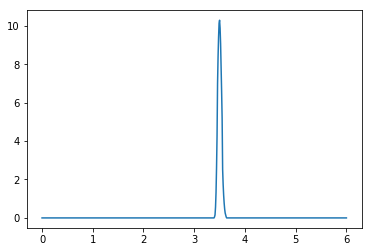

In [59]:
higher_redshift = nnpz_out[nnpz_out['z_true'] > 3][0]
pdz_vals, pdz_bins = higher_redshift['CoaddedPdz'], higher_redshift['CoaddedPdzBins']
pyplot.plot(pdz_bins, pdz_vals)

In [60]:
higher_redshift['z_true']

3.5009999

Looks kind of ok, no? Adding quantiles to the output and using the median.

In [73]:
diff = nnpz_out['Q_50'] - nnpz_out['z_true']
diff=diff[np.isnan(diff)==False]
err=diff*diff

(array([ 818.,   22.,    7.,    6.,    6.,    6.,    3.,    4.,    6.,
           2.,    3.,    2.,    4.,    2.,    2.,    2.,    0.,    2.,
           0.,    1.]),
 array([  8.88178420e-16,   6.18941212e-01,   1.23788242e+00,
          1.85682364e+00,   2.47576485e+00,   3.09470606e+00,
          3.71364727e+00,   4.33258848e+00,   4.95152969e+00,
          5.57047091e+00,   6.18941212e+00,   6.80835333e+00,
          7.42729454e+00,   8.04623575e+00,   8.66517696e+00,
          9.28411818e+00,   9.90305939e+00,   1.05220006e+01,
          1.11409418e+01,   1.17598830e+01,   1.23788242e+01]),
 <a list of 20 Patch objects>)

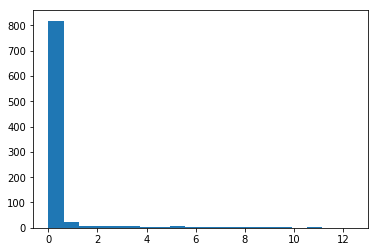

In [75]:
pyplot.hist(err, bins=20)